In [76]:
# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

# Data handling and numerical operations
import numpy as np
import pandas as pd
import random
import os

# Visualization
import matplotlib.pyplot as plt

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, 
    average_precision_score, confusion_matrix, 
    ConfusionMatrixDisplay
)

### Path system

In [79]:
# you need the current working directory NB: works both windows and linux 
current_working_directory = os.getcwd()
current_working_directory = os.path.dirname(current_working_directory)

# get the directory where I want to download the dataset
path_of_download = os.path.join(*['..', current_working_directory, 'Assignment 1', 'cookies_vs_chihuahua'])
print(f"[DIR] The directory of the current dataset is {path_of_download}")

[DIR] The directory of the current dataset is C:\Users\ayesh\Documents\UTU\CV & SF\Assignment 1\cookies_vs_chihuahua


### Dataset function

In [82]:
# here let s do some functions that we can re-use also for other assignment
def load_the_data_and_the_labels(data_set_path: str, target_size: tuple or None = None):
    try:
        dataset, labels, name_of_the_labels = list(), list(), list() 
        # let s loop here and we try to discover how many class we have 
        for class_number, class_name in enumerate(os.listdir(data_set_path)):
            full_path_the_data = os.path.join(data_set_path, class_name)
            print(f"[WALK] I am walking into {full_path_the_data}")
            
            # add the list to nam _list
            name_of_the_labels.append(class_name)
            
            for single_image in os.listdir(f"{full_path_the_data}"):
                full_path_to_image = os.path.join(*[full_path_the_data, single_image])
                
                # add the class number 
                labels.append(class_number)
                
                if target_size is None:
                    # let s load the image 
                    image = tf.keras.utils.load_img(full_path_to_image)
                else:
                    image = tf.keras.utils.load_img(full_path_to_image, target_size=target_size)
                
                # transform PIL object in image                    
                image = tf.keras.utils.img_to_array(image)
                
                # add the image to the ds list 
                dataset.append(image)
                
        return np.array(dataset, dtype='uint8'), np.array(labels, dtype='int'), name_of_the_labels
    except Exception as ex:
        print(f"[EXCEPTION] load the data and the labels throws exceptions {ex}")

### load train set

Loading the train set images from the local path. The images will have a width of 224 pixels and a height of 224 pixels and color channels 3. The number 3 represents the color channels (RGB).

In [86]:
# get the path of train set
train_set_path = os.path.join(*['..', path_of_download, 'cookies_vs_chihuahua', 'train'])

# target size for the the images.
target_size: tuple = (224, 224, 3)

# load the train dataset from the path
dataset, labels, label_names = load_the_data_and_the_labels(train_set_path, target_size)

[WALK] I am walking into C:\Users\ayesh\Documents\UTU\CV & SF\Assignment 1\cookies_vs_chihuahua\cookies_vs_chihuahua\train\chihuahua
[WALK] I am walking into C:\Users\ayesh\Documents\UTU\CV & SF\Assignment 1\cookies_vs_chihuahua\cookies_vs_chihuahua\train\muffin


### load test set

In [88]:
# get the path of test set
test_set_path = os.path.join(*['..', path_of_download, 'cookies_vs_chihuahua', 'test'])

# load the test dataset from the path
test_dataset, test_labels, test_label_names = load_the_data_and_the_labels(test_set_path, target_size)

[WALK] I am walking into C:\Users\ayesh\Documents\UTU\CV & SF\Assignment 1\cookies_vs_chihuahua\cookies_vs_chihuahua\test\chihuahua
[WALK] I am walking into C:\Users\ayesh\Documents\UTU\CV & SF\Assignment 1\cookies_vs_chihuahua\cookies_vs_chihuahua\test\muffin


### normalize the data

RGB values for images typically range from 0 to 255, and dividing by 255 ensures all values are normalized between 0 and 1. Models typically perform better when input data is within a consistent and small numerical range.

In [90]:
# Normalize the dataset
dataset_normalized = dataset.astype('float32') / 255.0
testset_normalized = test_dataset.astype('float32') / 255.0

### Split the data into training and test sets

In [92]:
# Split the dataset into training and test sets (30% for testing)
X_train, X_test, y_train, y_test = train_test_split(
    dataset_normalized,  # Features (image data)
    labels,              # Labels (corresponding class labels)
    test_size=0.3,       # 30% of the data will be used for testing
    random_state=42      # Ensures reproducibility of the split
)

print('Data loaded: train:',len(X_train),'test:',len(X_test))
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

Data loaded: train: 3313 test: 1420
X_train: (3313, 224, 224, 3)
y_train: (3313,)


The training data (`X_train`) is a 4th-order tensor of size (3313, 224, 224, 3), i.e. it consists of 3313 images of size 224*224 pixels. `y_train` is a 3313-dimensional vector containing the correct classes ("0", "1") for each training sample.

##### Here are the first 10 training images:

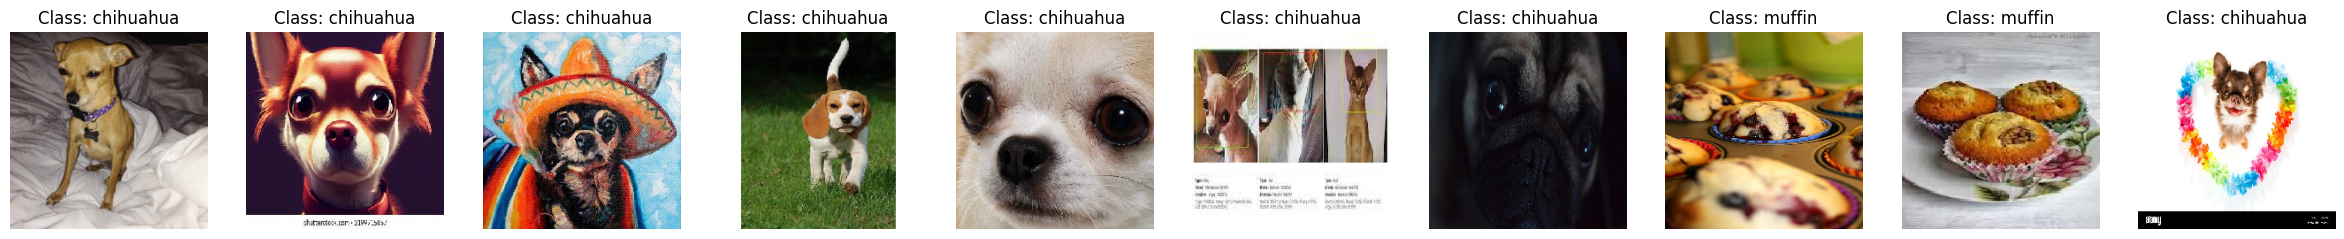

In [95]:
pltsize=3
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:], cmap="gray")
    plt.title('Class: '+ str(label_names[y_train[i]]))

### create a cnn with the following characteristics:
a.	Input layer
b.	Data augmentation, with random flip and random rotation.
c.	Two hidden layers each composed with the following characteristics: 16 conv2d units, max pooling 2d and batch normalization, the second one should have 24 conv2d units max pooling 2d and batch normalization. 
d.	After this, add a flatten layer and a dense layer with 8 units
e.	Add the final classifier (a  dense layer) with the correct number of output and activation


In [98]:
# Initialize a Sequential model in Keras, which allows layers to be added one by one in a linear stack for CNN.
model = models.Sequential()

# a. Input Layer
input_shape = (224, 224, 3)  # 224x224 RGB image with 3 color channels

#The InputLayer specify the shape of the input data for the model.
model.add(layers.InputLayer(shape=input_shape))

# b. Data augmentation, with random flip and random rotation.
model.add(layers.RandomFlip("horizontal_and_vertical"))
model.add(layers.RandomRotation(0.2))


# c. The convolutional layer applies a set of filters to the input image to detect features
# like edges, textures, or more complex patterns as the model learns.

# First Convolutional Layer
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())  # Batch normalization
model.add(layers.MaxPooling2D((2, 2)))  # Max pooling 2x2

# Second Convolutional Layer
model.add(layers.Conv2D(24, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())  # Batch normalization
model.add(layers.MaxPooling2D((2, 2)))  # Max pooling 2x2

# d. Flatten Layer
model.add(layers.Flatten())  # # Converts the 2D feature maps into a 1D vector for the fully connected layers

# Dense Layer with 8 units
model.add(layers.Dense(8, activation='relu'))  # Fully connected layer with 8 units and ReLU activation

# e. Final Classifier (Dense Layer)
# Binary classification (1 output unit). The value of this neuron will be between 0 and 1, 
# representing the probability of one of the classes.
num_classes = 1  
model.add(layers.Dense(num_classes, activation='sigmoid'))  # Sigmoid for binary classification

# Summary of the model
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_2 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 224, 224, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 112, 112, 24)        │           3,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 112, 112, 24)        │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 56, 56, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 75264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 8)                   │         602,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 606,217 (2.31 MB)

 Trainable params: 606,137 (2.31 MB)

 Non-trainable params: 80 (320.00 B)

# compile the model using Adam 

In [102]:
# Compile the model with Adam optimizer and binary cross entropy as loss function.
model.compile(
    optimizer=Adam(),  # Adam optimizer
    loss='binary_crossentropy',  # Binary cross entropy for binary classification
    metrics=['accuracy']  # Track accuracy during training
)

### Train the model with batch size 64 and epochs of 30

In [105]:
# Train the model
history = model.fit(
    X_train,              # Training data
    y_train,              # Training labels
    batch_size=64,        # Batch size for training
    epochs=30,            # Number of epochs for training
    validation_data=(X_test, y_test),  # Validation data for evaluation
    verbose=1             # Display progress during training
)

Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.5493 - loss: 0.9951 - val_accuracy: 0.5000 - val_loss: 3.7664
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.5274 - loss: 0.6568 - val_accuracy: 0.5366 - val_loss: 16.4507
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.5491 - loss: 0.6455 - val_accuracy: 0.5366 - val_loss: 27.3833
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6204 - loss: 0.6433 - val_accuracy: 0.5387 - val_loss: 29.3155
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.6156 - loss: 0.6289 - val_accuracy: 0.5415 - val_loss: 23.0708
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6228 - loss: 0.6351 - val_accuracy: 0.5993 - val_loss: 6.5385
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.6386 - loss: 0.6050 - val_accuracy: 0.6718 - val_loss: 4.1293
Epoch 8/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.6985 - loss: 0.5760 - val_accuracy: 0.7641 - val_l

### Evaluate the model and report the accuracy.

In [107]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

# Output the results
print(f"Model Accuracy on Test Data: {test_accuracy * 100:.2f}%")

45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.7435 - loss: 0.5133
Model Accuracy on Test Data: 74.08%


#### Make prediction with the test set and use a threshold of 0.5 as boundaries decision between the classes. 

In [129]:
# Make predictions on the test set
predictions = model.predict(testset_normalized)

# Apply threshold to convert probabilities to class labels (0 or 1)
predicted_classes = (predictions >= 0.5).astype(int)

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step


### Plot some predicted images.

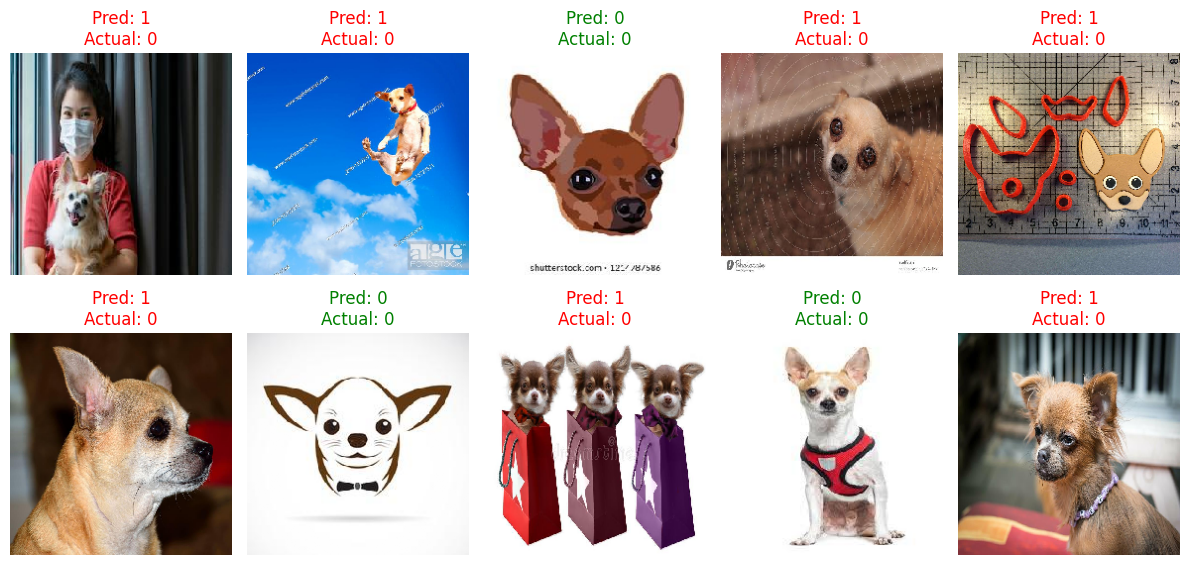

In [133]:
# function to plot the predicted images
def plot_predictions(images, true_labels, predicted_labels, num_images=10):
    plt.figure(figsize=(12, 6))
    
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.axis('off')

        # Actual labels of the images
        true_label = true_labels[i]

        # Predicted label by the model
        predicted_label = predicted_labels[i][0]

        # Print green title of the prediction is correct
        color = "green" if true_label == predicted_label else "red"
        plt.title(f"Pred: {predicted_label}\nActual: {true_label}", color=color)
    
    plt.tight_layout()
    plt.show()

# call the function to plot first 10 images with predicted classes
plot_predictions(testset_normalized, test_labels, predicted_classes)

### plot confusion matrix and ROC curve

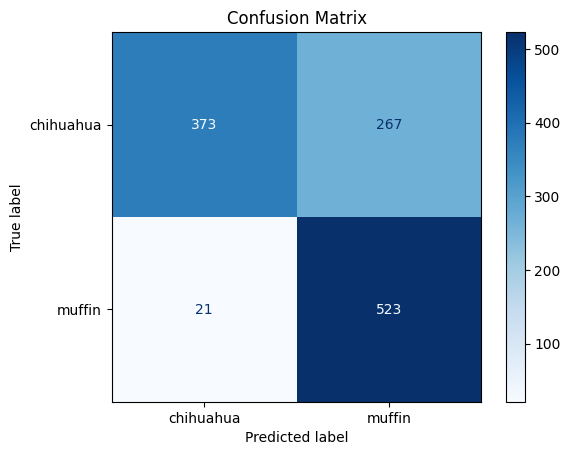

In [148]:
# Plot Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

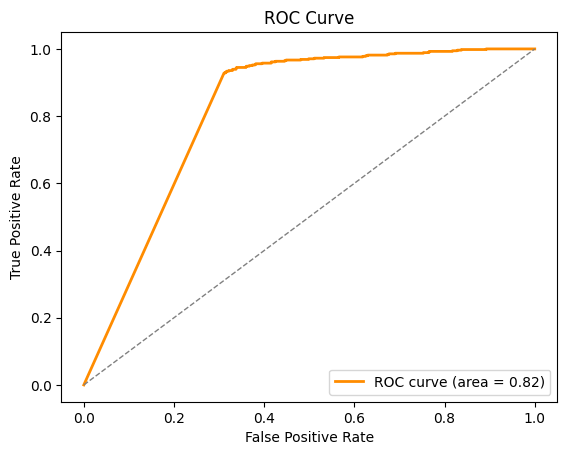

In [150]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(test_labels, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Why you need these evaluations systems?

These evaluation systems provide a comprehensive understanding of the model's performance:

1. Accuracy: Indicates the overall proportion of correct predictions, giving a basic measure of model success.

2. Confusion Matrix: Breaks down true positives, true negatives, false positives, and false negatives, helping identify specific types of errors the model makes.

3. Predicted Images: Visually shows if the model correctly classifies samples, providing insights into its strengths or weaknesses.

4. ROC Curve: Evaluates the model’s ability to distinguish between classes at different thresholds, with the AUC (Area Under the Curve) indicating how well the model performs overall.

These evaluations are essential for improving the model and ensuring it generalizes well to real-world data.

### Calcualte best testhold 

In [159]:
# Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(test_labels, predictions)

# Find the best threshold index
best_threshold_index = np.argmax(tpr - fpr)
best_threshold = thresholds[best_threshold_index]

print(f"Best Threshold: {best_threshold:.4f}")

Best Threshold: 0.7501


### Plot confusion matrix 

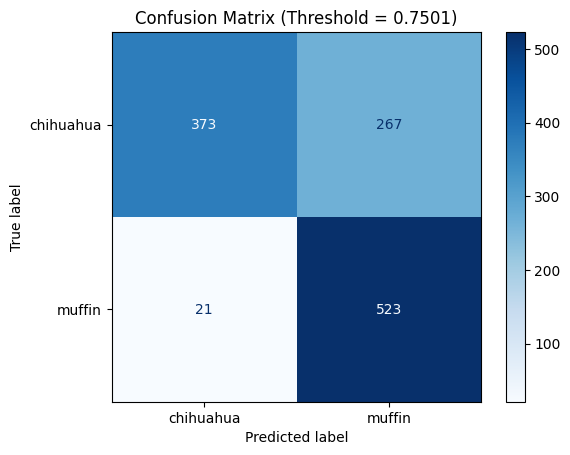

In [165]:
# Apply the best threshold
new_predictions = (predictions >= 0.7501).astype(int)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_names)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix (Threshold = {0.7501})")
plt.show()

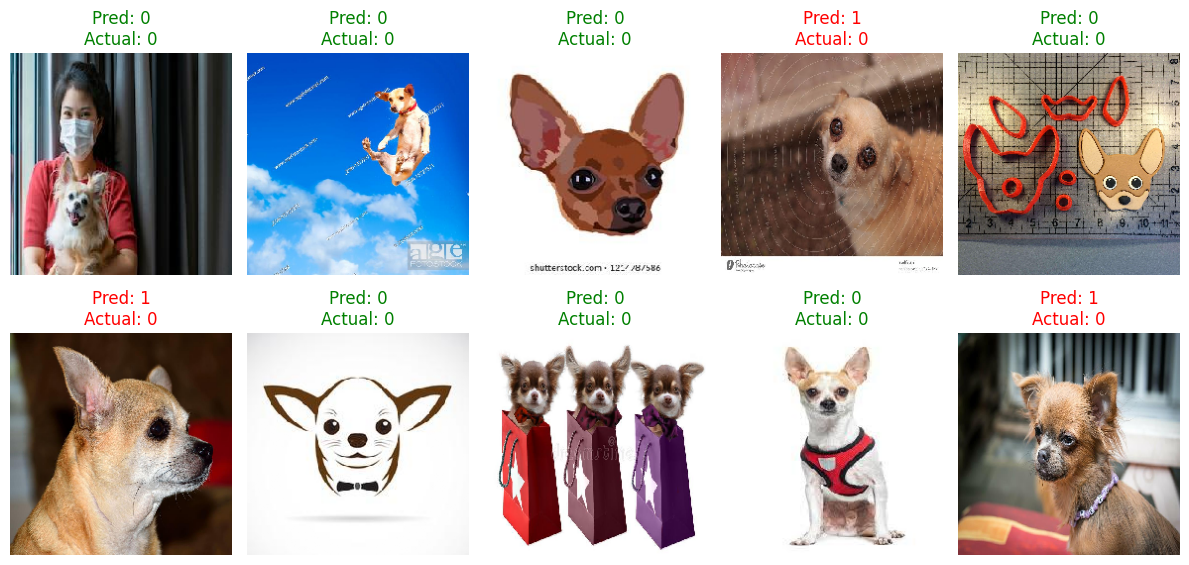

In [127]:
# re-plot the confusion matrix
plot_predictions(testset_normalized, test_labels, new_predictions)

After changing the decision threshold to the best possible value the model classified data points more accurately. This threshold optimizes the balance between correctly identifying positive samples and minimizing false positives.

What Happens:

Improved Model Performance: Better precision, recall, and accuracy.

Updated Confusion Matrix: The matrix will reflect changes based on the new threshold, showing fewer misclassifications.